In [3]:
from typing import TypedDict, Annotated, List, Dict, Optional

import operator


class FinancialData(TypedDict):
    ratios: Dict
    earnings_trend: str

class SentimentData(TypedDict):
    score: float
    summary: str
class InvestmentState(TypedDict):
    ticker: str
    messages: Annotated[List[str],operator.add]
    fundamental_data: Optional[FinancialData]
    Sentiment_data: Optional[SentimentData]
    current_step: str
    is_debated: bool


In [4]:
import yfinance as yf

In [5]:
import os
from dotenv import load_dotenv

# 1. Load the variables from .env into the environment
load_dotenv()

# 2. Retrieve the key
api_key = os.getenv("OPEN_API_KEY")

if not api_key:
    raise ValueError("API Key not found. Please set it in the .env file.")

print("Key loaded successfully!")

Key loaded successfully!


In [15]:
###{'pe_ratio': 33.4488, 'debt_to_equity': 102.63, 'revenue_growth': 0.157###

In [6]:
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, ToolMessage

In [22]:
from langchain_community.tools import YahooFinanceNewsTool
from langchain.tools import tool
import yfinance as yf

@tool
# Define custom tools for the agent to use
def get_fundamental_metrics(ticker: str):
    """Fetches P/E, Debt-to-Equity, and Revenue Growth for a given ticker."""
    stock = yf.Ticker(ticker)
    info = stock.info
    
    return {
        "pe_ratio": info.get("trailingPE"),
        "debt_to_equity": info.get("debtToEquity"),
        "revenue_growth": info.get("revenueGrowth"),
    }

# Combine tools
tools = [get_fundamental_metrics]

from langchain_openai import ChatOpenAI

# Initialize the LLM with tool binding
llm = ChatOpenAI(model="gpt-4o",api_key=api_key).bind_tools(tools)
def fundamental_analyst_node(state :InvestmentState):
    ticker= state['ticker']

    prompt=f""" 
You are an expert Fundamental Analyst. Analyze the financial metrics for {ticker}

1. Use the 'get_fundamental_metrics' tool to retrieve current data.

2. Assess the financial health based on P/E and Debt/Equity.

3. Return a concise, structure analysis.


 """
    
    response= llm.invoke([("system", prompt),("human" , f"Analyze {ticker}")])

    if response.tool_calls:
    # 3. Execute the tool (yfinance logic)
        tool_name = response.tool_calls[0]["name"]
        tool_args = response.tool_calls[0]["args"]
    
    # Simple dispatcher
    if tool_name == "get_fundamental_metrics":
        tool_result = get_fundamental_metrics.invoke(tool_args)

        print(f"tools result {tool_result}")

        messages = [
            SystemMessage(content=prompt),
            HumanMessage(content=f"Analyze {ticker}"),
            response, # Pass the AIMessage object directly
            ToolMessage(
                tool_call_id=response.tool_calls[0]["id"],
                content=str(tool_result)
            )
        ]
        
    # 4. Invoke again with the full history
        final_response = llm.invoke(messages)
        print(final_response)

    else:
        print(response)


#fundamental_analyst_node('AAPL')

In [25]:
def router(state: InvestmentState):
    # If we have both, go to synthesis
    if state.get("fundamental_analysis") and state.get("sentiment_analysis"):
        return "synthesis"
    
    # Otherwise, continue gathering data
    if not state.get("fundamental_analysis"):
        return "fundamental"
    return "sentiment"

In [19]:
from langchain_community.tools import DuckDuckGoSearchRun

# Initialize the tool
search_tool = DuckDuckGoSearchRun()

def sentiment_analyst_node(state: InvestmentState):
    ticker = state["ticker"]
    
    # The tool automatically handles the search via DuckDuckGo
    results = search_tool.invoke(f"market sentiment and news for {ticker}")
    
    # ... then pass 'results' to your LLM for analysis
    return {"sentiment_analysis": {"summary": results}}

In [33]:
def synthesis_node(state: InvestmentState):
    """
    Acts as the 'Chief Investment Officer'. 
    Reads the Fundamental and Sentiment data and produces a final verdict.
    """
    # 1. Access both data sources
    fund_data = state.get("fundamental_analysis", {})
    sent_data = state.get("sentiment_analysis", {})
    
    # 2. Instruct the LLM to synthesize
    prompt = f"""
    You are the Chief Investment Officer. Synthesize this data for {state['ticker']}:
    Fundamental: {fund_data}
    Sentiment: {sent_data}
    
    Produce a final Buy/Sell/Hold recommendation with a clear rationale.
    """
    
    # 3. Generate report
    response = llm.invoke(prompt)
    
    return {
        "final_report": response.content,
        "messages": ["Synthesis Analyst: Final report generated."]
    }

In [35]:
from langgraph.graph import END, StateGraph

graph= StateGraph(InvestmentState)
graph.set_entry_point("supervisor")
graph.add_node("fundamental_analyst",fundamental_analyst_node)
graph.add_node("sentiment_analyst",sentiment_analyst_node)
graph.add_node("supervisor",router)
graph.add_node("synthesis",synthesis_node)



graph.add_conditional_edges(
    "supervisor",
    router, 
    {
        "fundamental_analyst": "fundamental_analyst", # Map string to string
        "sentiment_analyst": "sentiment_analyst",
        "synthesis": "synthesis",      # Map string to string
        "__end__": END
    }
)
graph.add_edge("fundamental_analyst", "supervisor")
graph.add_edge("sentiment_analyst", "supervisor")
graph.add_edge("synthesis", END)


app= graph.compile()

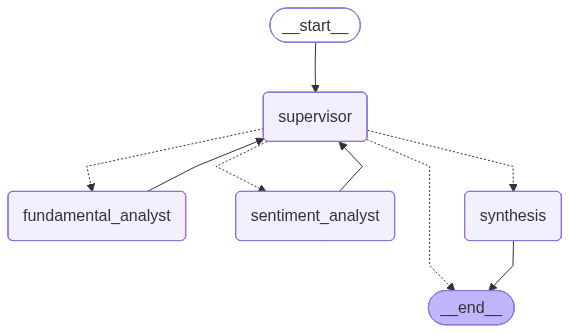

In [36]:
from IPython.display import Image, display

# You could see the errors with the below command
Image(app.get_graph().draw_mermaid_png())

In [32]:
# The initial state must match your InvestmentState schema
initial_input = {"ticker": "NVDA", "messages": []}

# Run the graph
final_state = app.invoke(initial_input)

# Access your final report
print(final_state)

InvalidUpdateError: Expected dict, got fundamental
For troubleshooting, visit: https://docs.langchain.com/oss/python/langgraph/errors/INVALID_GRAPH_NODE_RETURN_VALUE

In [14]:
print(sentiment_analyst_node('AAPL'))

{'sentiment_analysis': {'summary': "1 month ago - Apple’s Earnings Preview: Market Sentiment Brightens Ahead of Report - Foto: über boerse-global.de · As Apple prepares to release its quarterly results this week, a wave of cautious optimism is washing over the markets . 3 days ago - Should You Buy or Sell Apple Stock? Get The Latest AAPL Stock Analysis, Price Target, Dividend Info, Headlines, and Short Interest at MarketBeat. 1 month ago - (AAPL) Stock, AAPL:CA Stock ... Apple declined over 10% since December 2025 , driven by management shakeup and shifting AI strategy concerns rather than fundamental weakness. Recent sell-off stemmed from news of Tim Cook's potential 2026 exit ... 20 hours ago - Sentiment tilts toward renewed vigor despite broader tech rotations . Note: This discussion summary was generated from an AI condensation of post data. Apple insiders have traded $AAPL stock on the open market 16 times in the past 6 months. 6 days ago - Apple Inc. (AAPL, Financial) stock price

In [1]:
from langchain_community.tools import DuckDuckGoSearchRun

search = DuckDuckGoSearchRun()

search.invoke("Obama's first name?")

Impersonate 'firefox_135' does not exist, using 'random'


'2 days ago - Barack Hussein Obama II (born August 4, 1961) is an American politician who served as the 44th president of the United States from 2009 to 2017. A member of the Democratic Party, he was the first African American president. Obama previously served as a U.S. senator representing Illinois from ... 1 week ago - Barack Hussein Obama II (/bəˈrɑːk huːˈseɪn oʊˈbɑːmə/ ; born August 4, 1961) is an American politician and attorney. He was the 44th president of the United States from 2009 to 2017. November 25, 2025 - Obama is a surname. It most commonly refers to Barack Obama (born 1961), the 44th president of the United States. Obama is a common Fang masculine name in western Central Africa. 3 weeks ago - The selection was slow because Malia is allergic to animal dander; the president subsequently said that the choice had been narrowed down to either a labradoodle or a Portuguese Water Dog, and that they hoped to find a shelter animal. On April 12, 2009, it was reported that the Ob

In [34]:
from langchain_core.prompts import ChatPromptTemplate


prompt= ChatPromptTemplate.from_messages([ 
    ("system" , f"You are an expert Fundamental Analyst. Analyze the financial metrics for {ticker} 1. Return a concise, structure analysis"), 
    
    ("human" ,f"Analysze {ticker}")
    
    ])

chain = prompt | llm

response=chain.invoke({ "ticker" : 'AAPL'})

print(response.content)

To perform a fundamental analysis of Apple Inc. (AAPL), we should evaluate several key financial metrics and factors that impact the company's valuation and financial health. Here's a structured analysis:

### Revenue and Growth
- **Revenue**: Apple has consistently reported strong revenue growth driven by its diverse product line, including iPhones, iPads, Macs, wearables, home accessories, and services.
- **Growth Drivers**: Key growth drivers include innovation in product offerings, expansion in services (like Apple Music, iCloud, and Apple TV+), and growing market penetration in emerging markets.

### Profitability
- **Gross Margin**: Apple typically maintains a high gross margin compared to its peers, reflecting its premium pricing strategy and efficient supply chain management.
- **Operating Margin**: Despite high R&D and marketing expenses, Apple's operating margin remains robust due to its economies of scale.
- **Net Profit Margin**: Apple consistently achieves double-digit net

In [39]:
test_input = {
    "ticker": "TSLA",
    "messages": [],
    "fundamental_analysis": None,
    "sentiment_data": None,
    "technical_data": None,
    "next_step": "fundamental"
}

In [40]:
print(fundamental_analyst_node(test_input))

{'fundamental_analysis': '', 'messages': [AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 179, 'total_tokens': 197, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_64dfa806c7', 'id': 'chatcmpl-DCls0hzOCqcJui1A2hxQhsgSr3K0U', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019c8fa2-8e1b-7be0-ad19-e0edb0b3b19c-0', tool_calls=[{'name': 'get_fundamental_metrics', 'args': {'ticker': 'TSLA'}, 'id': 'call_tiYC7JP03stsjW8jMDEoOsbn', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata={'input_tokens': 179, 'output_tokens': 18, 'total_tokens': 197, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_de

In [ ]:
AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 121, 'total_tokens': 139, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_16396ea983', 'id': 'chatcmpl-DCm1ioHB98xy7QAvJyzciMSUK4wLs', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019c8fab-b922-7762-b6be-166dec304699-0', tool_calls=[{'name': 'get_fundamental_metrics', 'args': {'ticker': 'AAPL'}, 'id': 'call_HozhrSHNK0tuKDtXXNviLOWw', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata={'input_tokens': 121, 'output_tokens': 18, 'total_tokens': 139, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})